In [48]:
import numpy as np
from sklearn.preprocessing import StandardScaler
!wget -nc http://www.fredjo.com/files/ihdp_npci_1-100.train.npz
!wget -nc http://www.fredjo.com/files/ihdp_npci_1-100.test.npz 
 
def load_IHDP_data(training_data,testing_data,i=7):
    with open(training_data,'rb') as trf, open(testing_data,'rb') as tef:
        train_data=np.load(trf); test_data=np.load(tef)
        y=np.concatenate(   (train_data['yf'][:,i],   test_data['yf'][:,i])).astype('float32') #most GPUs only compute 32-bit floats
        t=np.concatenate(   (train_data['t'][:,i],    test_data['t'][:,i])).astype('float32')
        x=np.concatenate(   (train_data['x'][:,:,i],  test_data['x'][:,:,i]),axis=0).astype('float32')
        mu_0=np.concatenate((train_data['mu0'][:,i],  test_data['mu0'][:,i])).astype('float32')
        mu_1=np.concatenate((train_data['mu1'][:,i],  test_data['mu1'][:,i])).astype('float32')
 
        data={'x':x,'t':t,'y':y,'t':t,'mu_0':mu_0,'mu_1':mu_1}
        data['t']=data['t'].reshape(-1,1) #we're just padding one dimensional vectors with an additional dimension 
        data['y']=data['y'].reshape(-1,1)
        #rescaling y between 0 and 1 often makes training of DL regressors easier
        data['y_scaler'] = StandardScaler().fit(data['y'])
        data['ys'] = data['y_scaler'].transform(data['y'])
 
    return data
 
data =load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

X,y, t = data['x'], data['y'], data['t']

File ‘ihdp_npci_1-100.train.npz’ already there; not retrieving.

File ‘ihdp_npci_1-100.test.npz’ already there; not retrieving.



In [1]:
import pandas as pd
data = pd.read_csv("data_processed_arnaud.csv")
data.set_index("Unnamed: 0", drop=True, inplace=True)
data.index.name = None
data

,bicarbonate,wbc,lactate_cat,creatinine,sodium,temperature,potassium,glucose,hospital_expire_flag,treatment,chf,esrd,chf.esrd,sepsis.only
0,23.0,13.3,0,0.7,145.0,38.40,2.8,116.0,0,22.379091,0,0,0,1
1,28.0,17.5,0,0.8,142.0,37.06,4.2,114.0,0,15.750969,0,0,0,1
2,23.0,15.1,1,1.8,137.0,37.28,4.9,115.0,0,26.118877,0,0,0,1
3,17.0,27.5,0,1.2,143.0,36.56,3.4,103.0,0,13.550136,0,0,0,1
4,28.0,NaN,0,0.7,134.0,35.94,4.1,135.0,0,18.515460,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14793,24.0,5.5,0,1.3,136.0,37.72,5.9,190.0,0,13.845730,0,0,0,1
14794,22.0,3.7,1,0.8,145.0,36.72,3.5,81.0,1,0.000000,0,0,0,1
14795,26.0,7.3,5,1.8,138.0,36.44,4.4,165.0,1,10.105659,1,0,0,0
14796,14.0,15.0,1,4.8,140.0,36.33,5.5,224.0,0,8.420172,1,1,1,0


In [2]:
data = data.dropna()

In [3]:
from pickle import load

scaler = load(open('scaler.pkl', 'rb'))

In [4]:
scaler.transform(data.treatment.to_numpy().reshape(-1, 1))

array([[0.55202198],
       [0.42707711],
       [0.61041494],
       ...,
       [0.30661536],
       [0.2759136 ],
       [0.28198651]])

<AxesSubplot:>

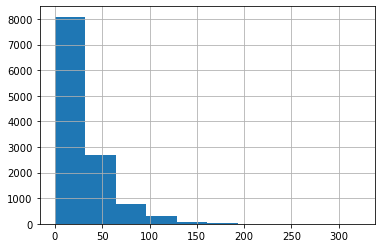

In [5]:
data.treatment.hist()

In [6]:
covariates_cols = data.columns[:8]
outcome = "hospital_expire_flag"
treatment = "treatment"

X = data[covariates_cols].to_numpy(dtype="float32")
t = data[treatment].to_numpy(dtype="float32").reshape(-1,1)
y = data[outcome].to_numpy(dtype="float32").reshape(-1,1)


In [5]:
n_treatment = 10
t = (t*(n_treatment-1)).astype("int")

In [7]:
from tarNET import tarNET
import tensorflow as tf

normalizer_layer = tf.keras.layers.Normalization(axis=None)
normalizer_layer.adapt(X)
model = tarNET(output_dim=1, n_treatments=10, normalizer_layer=normalizer_layer, scaler=scaler)


2022-06-09 17:47:12.068804: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD, Adam

from IPython.display import clear_output

val_split = 0.2
batch_size = 64
verbose = 1
i = 0
tf.random.set_seed(i)
np.random.seed(i)

sgd_callbacks = [
    TerminateOnNaN(),
    EarlyStopping(monitor="val_loss", patience=40, min_delta=0.0),
    ReduceLROnPlateau(
        monitor="loss",
        factor=0.5,
        patience=5,
        verbose=verbose,
        mode="auto",
        min_delta=0.0,
        cooldown=0,
        min_lr=0,
    ),
]


adam_callbacks = [
    TerminateOnNaN(),
    EarlyStopping(monitor="val_loss", patience=20, min_delta=0.0),
]

# optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)


model.compile(
    optimizer=Adam(),  # SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
    loss=loss,
    metrics=tf.keras.metrics.BinaryAccuracy(),
)

history = model.fit(
    x=[X, t],  # [data["x"], data["t"]],
    y=y,  # data['y'],
    callbacks=adam_callbacks,
    validation_split=val_split,
    epochs=100,
    batch_size=batch_size,
    verbose=verbose,
)

clear_output()

acc = history.history["binary_accuracy"]
val_acc = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

Epoch 1/100


NotImplementedError: in user code:

    File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    NotImplementedError: Exception encountered when calling layer "tar_net" (type tarNET).
    
    in user code:
    
        File "/Users/arnaudpetit/Documents/Programmation/MIT/continuous_treatment/tarNET/models/tarNET.py", line 76, in call  *
            treatment_cat = tf.cast(
        File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/sklearn/preprocessing/_data.py", line 2772, in transform  *
            X = self._check_inputs(X, in_fit=False, copy=self.copy)
        File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/sklearn/preprocessing/_data.py", line 2702, in _check_inputs  *
            X = self._validate_data(X, reset=in_fit,
        File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/sklearn/base.py", line 420, in _validate_data  *
            X = check_array(X, **check_params)
        File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1038, in inner_f  *
            return f(*args, **kwargs)
        File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/sklearn/utils/validation.py", line 673, in check_array  *
            array = np.asarray(array, order=order, dtype=dtype)
        File "/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/numpy/core/_asarray.py", line 83, in asarray  **
            return array(a, dtype, copy=False, order=order)
    
        NotImplementedError: Cannot convert a symbolic Tensor (IteratorGetNext:1) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
    
    
    Call arguments received:
      • x=('tf.Tensor(shape=(None, 8), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)')


In [10]:
treatment_cat = tf.cast(scaler.transform(t) * (9), tf.int32)
treatment_cat

<tf.Tensor: shape=(11981, 1), dtype=int32, numpy=
array([[4],
       [3],
       [5],
       ...,
       [2],
       [2],
       [2]], dtype=int32)>

In [11]:
x = tf.random.normal((10,2))
y = tf.random.normal((10,1))


tf.keras.layers.Concatenate()([x, y])

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[-0.82223016,  0.3449639 , -0.12575623],
       [ 0.5016385 , -0.96860427, -0.46677873],
       [ 2.0880806 ,  2.5090044 , -0.4480631 ],
       [ 0.0569069 , -0.00342684, -1.7664938 ],
       [ 0.4463921 ,  0.74810964, -1.4654588 ],
       [ 0.6412715 ,  0.05723069,  1.4187601 ],
       [ 1.0584769 , -0.57483643,  0.33001095],
       [ 0.20358515, -2.3415418 , -0.95508343],
       [-0.53358316,  1.0723833 ,  0.02041745],
       [-0.2298816 , -0.34991977,  0.806119  ]], dtype=float32)>